In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
import copy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import statistics
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras import backend as K
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.optimizers import SGD, Adam
import random
from keras._tf_keras.keras.metrics import Recall

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/729172018.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-04 21:16:40.513005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class CustomMLPClassifier:
    def __init__(self, hidden_layer_size = 100, max_iter=100, random_state=None, input_dim = 16):
        if random_state:
            tf.random.set_seed(random_state)
            np.random.seed(random_state)
            random.seed(random_state)
        self.model = Sequential([
            Dense(hidden_layer_size, activation='relu', input_dim=input_dim),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        max_iter = 20
        self.max_iter = max_iter
        self.random_state = random_state

    def compile_model(self):
        optimizer=Adam(learning_rate=0.0002,)
        loss='binary_crossentropy'
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[Recall()])

    def fit(self, X_train, y_train, **kwargs):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = y_train.values
        X_train = np.asarray(X_train).astype('float32')
        y_train = np.asarray(y_train).astype('float32')
        self.model.fit(X_train, y_train, epochs=self.max_iter, batch_size=32, verbose=1, initial_epoch=1, validation_split=0.1, shuffle=False, **kwargs)

    def predict(self, X_test):
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        X_test = np.asarray(X_test).astype('float32')
        dta = self.model.predict(X_test)
        arr_list = dta.flatten().tolist()
        grtr = 0
        lssr = 0
        arr_list_int = []
        for k in arr_list:
            if k > 0.5:
                arr_list_int.append(1)
                grtr = grtr + 1
            else:
                arr_list_int.append(0)
                lssr = lssr + 1

        return arr_list_int

In [3]:
class DataAnalyzer:
    def __init__(self, with_smote = True, algo = "knn"):
        file_path = 'bank-full.csv'

        self.dataset = pd.read_csv(file_path, header=None, sep=';')
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.original_dataset = self.dataset
        self.with_smote = with_smote
        self.algo = algo
        self.encode_categorical()

    
    def encode_categorical(self):
        label_encoder = LabelEncoder()
        for column in self.dataset.columns:
            if column in ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "y"]:  # Check if column is 'diagnosis'
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset.loc[:, column] = encoded_values
            elif column in ["balance", "age", "duration"]:  # Convert all other columns to 'double'
                self.dataset.loc[:, column] = self.dataset[column].astype(float)
            else:
                self.dataset.loc[:, column] = self.dataset[column].astype(int)
        
        self.dataset["y"] = self.dataset["y"].astype(int)
    

    def show_class_distribution(self):
        target_column = 'y'
        # Load your dataset into a pandas DataFrame

        # Step 2: Inspect the Target Variable
        class_distribution = self.dataset[target_column].value_counts()

        # Step 3: Visualize the Distribution
        class_distribution.plot(kind='bar', title='Target Variable Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

    def show_heat_map(self, dataset = None):
        if dataset is None:
            corr_matrix = self.dataset.corr()
        else:
            corr_matrix = dataset.corr()
        plt.figure(figsize=(20, 20))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def get_x_and_Y(self):
        self.X = self.dataset.drop('y', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['y']
        return (self.X, self.y)
    
    def perform_manual_splitting_without_cv(self):
        smote = SMOTE(random_state=42)
        X_train, self.X_test_final, y_train, self.y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if self.with_smote:
            self.X_train, self.y_train = smote.fit_resample(X_train, y_train)
        else:
            self.X_train, self.y_train = X_train, y_train
    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        smote = SMOTE(random_state=42)
        X_train, X_temp, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)
        if self.with_smote:
            self.X_train, self.y_train = smote.fit_resample(X_train, y_train)
        else:
            self.X_train, self.y_train = X_train, y_train
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
    
    def perform_kfold_cv(self, num_of_columns = None):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if num_of_columns:
            X_train = copy.deepcopy(X_train.iloc[:, :num_of_columns])
            X_test_final = copy.deepcopy(X_test_final.iloc[:, :num_of_columns])
        self.X_train = X_train
        self.y_train = y_train.astype(int)
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final.astype(int)
        if self.algo == "knn":
            classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        elif self.algo == "rf":
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.algo == "svm":
            classifier = SVC(kernel='rbf', random_state=42)
        elif self.algo == "logreg":
            classifier = LogisticRegression(random_state=42)
        elif self.algo == "nn":
            custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
            custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
            classifier = custom_mlp

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_avg_score = 0.0 

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index].astype(int), y_train.iloc[val_index].astype(int)

            # Train the model on the training fold
            smote = SMOTE(random_state=42)
            if self.with_smote:
                X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)
            else:
                X_train_smote, y_train_smote = X_train_fold, y_train_fold
            classifier.fit(X_train_smote, y_train_smote)

            # Evaluate the model on the validation fold
            y_val_pred = classifier.predict(X_val_fold)
            score = accuracy_score(y_val_fold, y_val_pred)

            # Update the best model if the current model has a better average performance
            if score > best_avg_score:
                best_avg_score = score
                best_model = classifier
            scores.append(score)
        
        self.classifier = best_model
        return(best_avg_score, scores)
    
    def perform_filter_methods(self):
        data = copy.deepcopy(self.dataset)
        X = copy.deepcopy(data).drop(columns=['y'])  # Features
        print("total features = ", len(X.columns))
        y = copy.deepcopy(data['y']).astype(int) 
        # Calculate Mutual Information scores
        mi_scores = mutual_info_classif(X, y)
        # Select features with MI score > 0.5
        selected_features = X.columns[mi_scores > 0.01]
        print("selected features with high mutual information with the target = ", len(selected_features))
        # Calculate correlation matrix
        corr_matrix = X[selected_features].corr().abs()
        copy_ds = copy.deepcopy(data[selected_features])
        # Remove one of two highly correlated features
        to_drop = set()
        dropped_columns = {}
        for i in range(len(corr_matrix.columns)):
            if i not in dropped_columns:
                for j in range(len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.8 and i!=j and j not in dropped_columns and i not in dropped_columns and i!=j:
                        
                        colname_i = corr_matrix.columns[i]
                        colname_j = corr_matrix.columns[j]
                        # Calculate the Mutual Information score of each feature with the target variable
                        mi_i = mutual_info_classif(X[colname_i].values.reshape(-1, 1), y)[0]
                        mi_j = mutual_info_classif(X[colname_j].values.reshape(-1, 1), y)[0]
                        # Keep the feature with higher Mutual Information score
                        if mi_i > mi_j:
                            to_drop.add(colname_j)
                            dropped_columns[j] = colname_j
                        else:
                            to_drop.add(colname_i)
                            dropped_columns[i] = colname_i
        final_selected_features = selected_features.drop(to_drop)
        print("final selected features after removing one of two correlated features = ", len(final_selected_features))
        self.dataset = self.dataset[final_selected_features]
        self.dataset["y"] = data["y"]
        self.show_heat_map()
        return self.dataset
    
    def perform_wrapper_method(self):
        feature_scores = []
        feature_scores_dict = {}
        total_num_of_columns = len(self.X.columns)
        for i in range(1,total_num_of_columns+1):
            newAnlyzr = DataAnalyzer(with_smote=self.with_smote)
            newAnlyzr.get_x_and_Y()
            (best_avg_score, scores) = newAnlyzr.perform_kfold_cv(num_of_columns=i)
            mean_score, y_tst, y_prd = newAnlyzr.get_accuracy()
            feature_scores.append((i, mean_score))
            feature_scores_dict[i] = mean_score
        self.feature_scores = feature_scores
        additional_feature_penalty = -0.05
        score_weight = 0.95
        adjusted_scores = []
        best_num_of_features = 1
        best_adjusted_score = 0
        for (j, mn_score) in feature_scores:
            adjusted_score = mn_score*score_weight + j*additional_feature_penalty/total_num_of_columns
            adjusted_scores.append((j, adjusted_score))
            if adjusted_score > best_adjusted_score:
                best_adjusted_score = adjusted_score
                best_num_of_features = j
        best_score = feature_scores_dict[best_num_of_features]

        return {
            "best_num_of_features": best_num_of_features,
            "best_score": best_score
        }
    
    def plot_wrapper_scores(self):
        x_values, y_values = zip(*self.feature_scores)
        # Create a Plotly trace
        trace = go.Scatter(x=x_values, y=y_values, mode='lines+markers')

        # Create a Plotly layout
        layout = go.Layout(
            title='Wrapper Method Feature Scores',
            xaxis=dict(title='Number of Features'),
            yaxis=dict(title='Accuracy')
        )

        # Create a Plotly figure
        fig = go.Figure(data=[trace], layout=layout)

        # Display the plot
        fig.show()

    def perform_pca(self, n_components=None):
        # Standardize the data
        scaler = StandardScaler()
        data = self.X
        standardized_data = scaler.fit_transform(data)

        # Create PCA object
        pca = PCA(n_components=n_components)

        # Fit and transform the data
        pca_data = pca.fit_transform(standardized_data)

        # Create a DataFrame for the PCA results
        pca_columns = [f"PC{i+1}" for i in range(pca_data.shape[1])]
        pca_df = pd.DataFrame(data=pca_data, columns=pca_columns)

        # Concatenate with original dataset
        self.X = pca_df

    
    def perform_without_cv(self):
        if self.algo == "knn":
            classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        elif self.algo == "rf":
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.algo == "svm":
            classifier = SVC(kernel='rbf', random_state=42)
        elif self.algo == "logreg":
            classifier = LogisticRegression(random_state=42)
        elif self.algo == "nn":
            custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
            custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
            classifier = custom_mlp
        self.classifier = classifier
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred1)
        return self.ac_final, self.y_test_final
    
    def perform_knn(self):
        self.classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = accuracy_score(self.y_cv,y_pred1)
        return self.ac_cv
    
    def perform_random_forest(self):
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize the Random Forest Classifier
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_svm(self):
        self.classifier = SVC(kernel='rbf', random_state=42)  # Initialize the SVM Classifier with RBF kernel
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_logistic_regression(self):
        self.classifier = LogisticRegression(random_state=42)  # Initialize the Logistic Regression Classifier
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_neural_network(self):
        custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
        custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
        self.classifier = custom_mlp
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred_final)
        return self.ac_final, self.y_test_final, y_pred_final

class Master:
    def __init__(self, with_smote = True, algo = "knn"):
        self.results = {}
        self.with_smote = with_smote
        self.algo = algo

    def print_classification_report(self, y_true, y_pred):
        report = classification_report(y_true, y_pred, target_names=['Negative Class', 'Positive Class'], output_dict=True)
        print("{:<20} {:<15} {:<15} {:<15} {:<15}".format('', 'precision', 'recall', 'f1-score', 'support'))
        for class_name, metrics in report.items():
            if class_name in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            print("{:<20} {:<15.2f} {:<15.2f} {:<15.2f} {:<15}".format(class_name,
                                                                       metrics['precision'],
                                                                       metrics['recall'],
                                                                       metrics['f1-score'],
                                                                       metrics['support']))
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_without_cv(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_without_cv()
        rslts, y_pred = anlyzr.perform_without_cv()
        self.results["run without cv"] = rslts
        self.print_classification_report(anlyzr.y_test_final, y_pred)

    def run_with_cv(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["run with cv"], y_test_final, y_pred_final = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_kfold(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        (best_avg_score, scores) = anlyzr.perform_kfold_cv()
        rslt, y_test_final, y_pred_final =  anlyzr.get_accuracy()
        self.results["after_k_fold_run"] = {
            "best kfold cv score": best_avg_score,
            "scores": scores,
            "final kfold score on test dataset": rslt
        }
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_filter(self):
        # Implement feature selection using filter method (e.g., correlation)
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.perform_filter_methods()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["with_filter_method"], y_test_final, y_pred_final  = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_wrapper(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        self.results = anlyzr.perform_wrapper_method()
        anlyzr.plot_wrapper_scores()

    def run_with_pca(self):
        # Implement feature selection using PCA
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_pca(n_components=2)
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["with_pca"], y_test_final, y_pred_final  = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)
    
    def run_cv_problem(self):
        self.run_without_cv()
        self.run_with_cv()
        self.run_with_kfold()
        return self.results



In [39]:
cv_mstr = Master(with_smote=True)
cv_mstr.run_cv_problem()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       1.00            1.00            1.00            7980.0         
Positive Class       1.00            1.00            1.00            1063.0         


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.96            0.77            0.85            7999.0         
Positive Class       0.29            0.72            0.42            1044.0         


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.96            0.77            0.85            7980.0         
Positive Class       0.30            0.76            0.43            1063.0         
run without cv 0.7615835452836448
run with cv 0.7671126838438571
after_k_fold_run {'best kfold cv score': 0.7729849301811144, 'scores': [0.7666574509261819, 0.761680951064418, 0.7638927287807575, 0.7660721692243883, 0.7729849301811144], 'final kfold score on test dataset': 0.765232776733385}


,method,result
0,run without cv,0.761584
1,run with cv,0.767113
2,best kfold cv score,0.772985
3,scores,"[0.7666574509261819, 0.761680951064418, 0.7638..."
4,final kfold score on test dataset,0.765233


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


total features =  16
selected features with high mutual information with the target =  9
final selected features after removing one of two correlated features =  8


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset["y"] = data["y"]


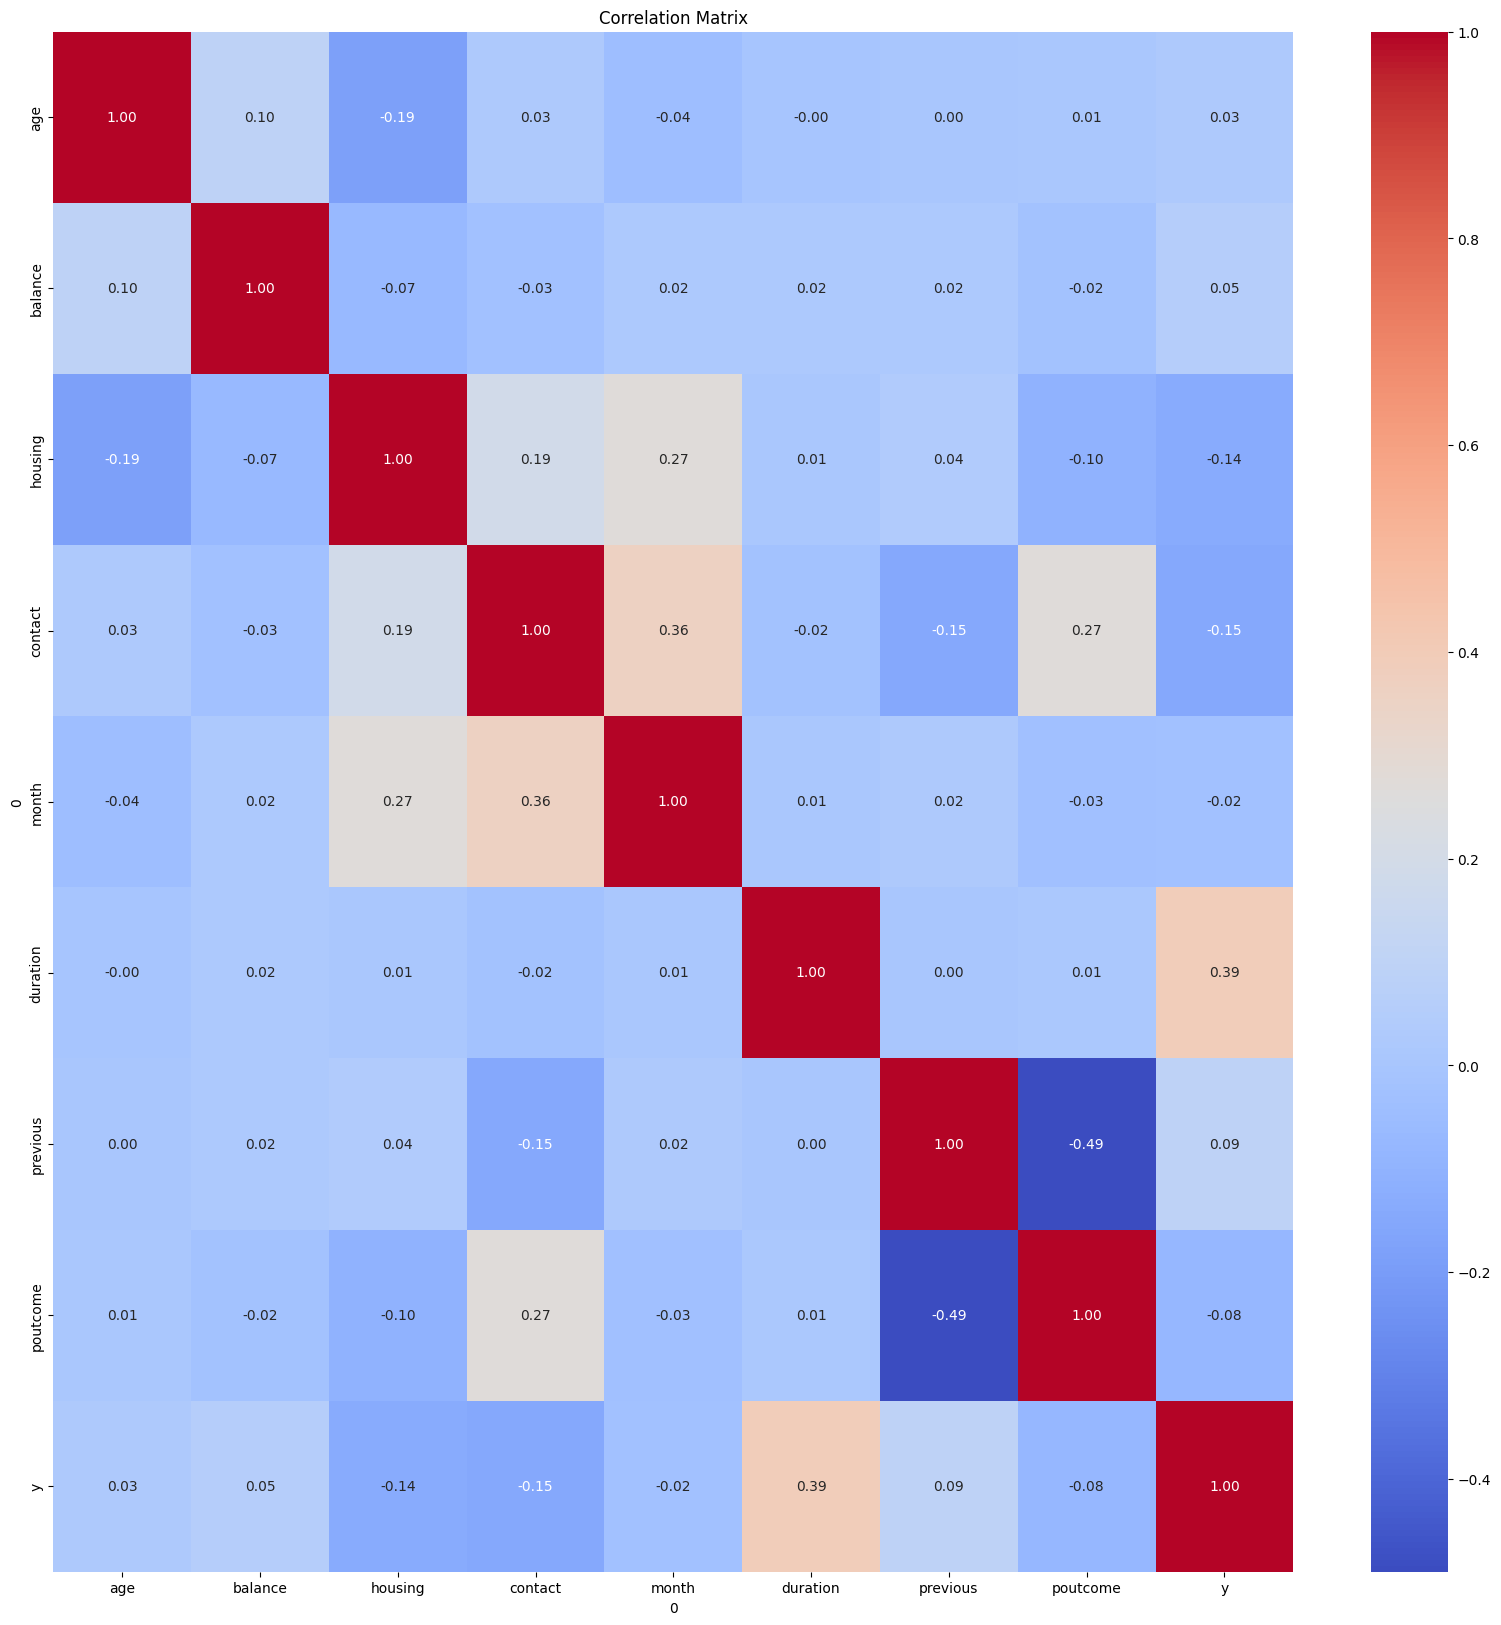

                     precision       recall          f1-score        support        
Negative Class       0.94            0.75            0.83            7999.0         
Positive Class       0.25            0.65            0.36            1044.0         
with_filter_method 0.7347119318810129


,method,result
0,with_filter_method,0.734712


In [41]:
cv_mstr = Master(with_smote=True)
cv_mstr.run_with_filter()
cv_mstr.organize_results()

In [42]:
cv_mstr = Master(with_smote=True)
cv_mstr.run_with_pca()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_50343/2030444915.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.92            0.69            0.79            7999.0         
Positive Class       0.18            0.52            0.27            1044.0         
with_pca 0.6731173283202477


,method,result
0,with_pca,0.673117


In [6]:
cv_mstr = Master(with_smote=True, algo="knn")
cv_mstr.run_with_cv()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/48491943.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.96            0.77            0.85            7999.0         
Positive Class       0.29            0.72            0.42            1044.0         
run with cv 0.7671126838438571


,method,result
0,run with cv,0.767113


In [7]:
cv_mstr = Master(with_smote=True, algo="rf")
cv_mstr.run_with_cv()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/48491943.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.93            0.96            0.94            7999.0         
Positive Class       0.58            0.47            0.52            1044.0         
run with cv 0.9001437576025655


,method,result
0,run with cv,0.900144


In [8]:
cv_mstr = Master(with_smote=True, algo="svm")
cv_mstr.run_with_cv()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/48491943.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.95            0.78            0.86            7999.0         
Positive Class       0.29            0.68            0.40            1044.0         
run with cv 0.7704301669799846


,method,result
0,run with cv,0.77043


In [9]:
cv_mstr = Master(with_smote=True, algo="logreg")
cv_mstr.run_with_cv()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/48491943.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


                     precision       recall          f1-score        support        
Negative Class       0.96            0.79            0.87            7999.0         
Positive Class       0.32            0.75            0.45            1044.0         
run with cv 0.785027092778945


/Users/mirbilal/Desktop/ASSGNS_MLL/assgn_3/assgn_3_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,method,result
0,run with cv,0.785027


In [10]:
cv_mstr = Master(with_smote=True, algo="nn")
cv_mstr.run_with_cv()
cv_mstr.organize_results()

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_90646/48491943.py:5: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(file_path, header=None, sep=';')


Epoch 2/20


/Users/mirbilal/Desktop/ASSGNS_MLL/assgn_3/assgn_3_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3601 - recall_3: 0.2752 - val_loss: 0.0020 - val_recall_3: 1.0000
Epoch 3/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.5502 - recall_3: 0.5841 - val_loss: 0.0031 - val_recall_3: 1.0000
Epoch 4/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.4763 - recall_3: 0.6035 - val_loss: 0.0063 - val_recall_3: 1.0000
Epoch 5/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - loss: 0.4281 - recall_3: 0.6269 - val_loss: 0.0059 - val_recall_3: 1.0000
Epoch 6/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - loss: 0.4217 - recall_3: 0.6425 - val_loss: 0.0059 - val_recall_3: 1.0000
Epoch 7/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - loss: 0.4165 - recall_3: 0.6460 - val_loss: 0.0059 - val_recall_3: 1.0000
Epoch 8/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 0.4115 - recall_3: 0.6462 - val_loss: 0.0059 - val_recall_3: 1.0000
Epoch 9/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.4069 - recall_3: 0.6493

,method,result
0,run with cv,0.15747
